## Семинар 4: "Методы оптимизации"

ФИО: Бетев Иван Алексеевич

In [12]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

In [13]:
import matplotlib
np.__version__, matplotlib.__version__

('1.20.3', '3.7.0')

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, RMSProp, Adadelta, Adam.

### Часть 1: Реализация методов

Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

In [14]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):   
        steps = np.arange(i+1)
        # left = max(0, i-20) # show last 20 steps
        left = 0
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)
    
    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

Сделаем задачу регрессии

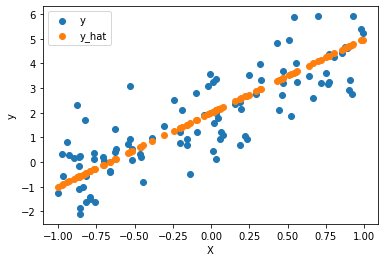

In [15]:
size = 100
X = torch.ones(size, 2)  # X[:, 1] = bias
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

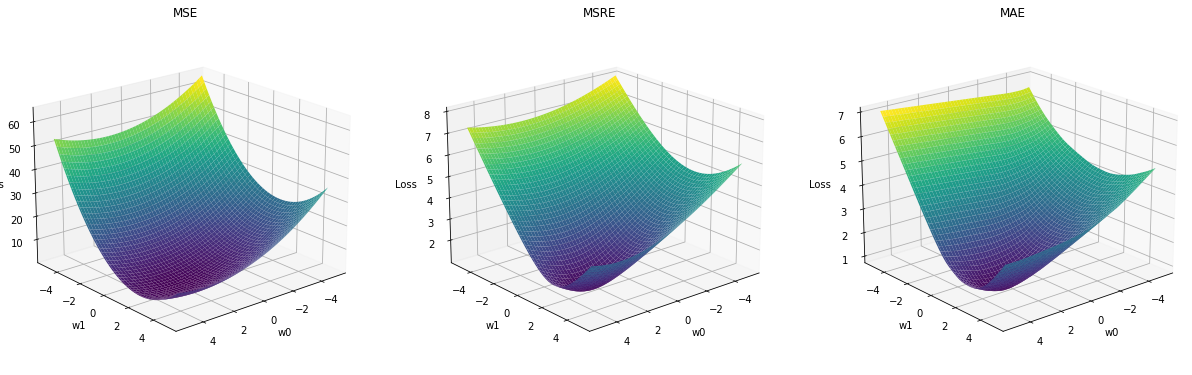

In [16]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

<i> 1.1 Реализуйте методы SGD, Momentum, NAG, Adagrad, Adadelta, Adam.</i> **(1 балл)**

In [17]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()
    
    def pre_step(self):
        pass
    
    def step(self):
        pass
    
    def update_param(self, p):
        raise NotImplementedError()


In [18]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [19]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in optim_list:
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }
    
    return loss_animator.animate(num_iter, data, step_skip=step_skip)

SGD

$\theta_{t+1} = \theta_{t} - \eta \nabla J$

In [20]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad
        

Momentum

$\nu_t = \gamma \nu_{t-1} + \eta_t \nabla J(\theta_{t-1})$

$\theta_t = \theta_{t-1} - \nu_t$

In [21]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma
        self.v = [torch.zeros_like(p) for p in self.params]
        
    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.v[i] = self.gamma * self.v[i] + self.lr * p.grad
                p -= self.v[i]
        

NAG

$\nu_t = \gamma \nu_{t-1} + \eta_t \nabla J(\theta_{t-1} - \gamma \nu_{t-1})$

$\theta_t = \theta_{t-1} - \nu_t$

Сделаем замену

$\theta_t = \theta_{t-1} - \gamma \nu_{t-1} - \eta_t \nabla J(\theta_{t-1} - \gamma \nu_{t-1})$

$\theta_t = \theta'_{t-1} - \eta_t \nabla J(\theta'_{t-1})$

In [22]:
class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma
        self.v = [torch.zeros_like(p) for p in self.params]
        
    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                p -= self.gamma * self.v[i]
                grad = self.lr * p.grad
                self.v[i] = self.gamma * self.v[i] + grad
                p -= grad
                
        

Adagrad

$g_t = \nabla_\theta J(\theta)$

$G_t = \sum_{k=0}^t g_k^2$

$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{G_t+\epsilon}}$

In [23]:
class Adagrad(Optimizer):
    def __init__(self, params, lr=1e-2, epsilon=1e-8):
        super().__init__(params)
        self.lr = lr
        self.epsilon = epsilon
        self.G = [torch.zeros_like(p) for p in self.params]
        
    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                g = p.grad
                self.G[i] += g**2
                p -= self.lr * g / np.sqrt(self.G[i] + self.epsilon)
        

Adadelta

$E[g^2]_t = \gamma E[g^2]_{t-1} + (1 - \gamma)g_t^2$

$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{E[g^2]_t + \epsilon}}$ 

$RMS[g^2]_t = \sqrt{E[g^2]_t + \epsilon}$

уберем learning rate

$E[\Delta \theta^2]_t = \gamma E[\Delta \theta^2]_{t-1} + (1 - \gamma)\Delta \theta^2_t$

$RMS[\Delta \theta^2]_t = \sqrt{E[\Delta \theta^2]_t + \epsilon}$

$\Delta\theta_t = -\frac{RMS[\Delta\theta]_{t-1}}{RMS[g]_t}g_t$

$\theta_{t+1} = \theta_t + \Delta\theta_t$

In [40]:
class Adadelta(Optimizer):
    def __init__(self, params, epsilon=1e-8, gamma=0.9):
        super().__init__(params)
        self.gamma = gamma
        self.epsilon = epsilon
        self.Eg = [torch.zeros_like(p) for p in self.params]
        self.Edtheta = [torch.ones_like(p) for p in self.params]
        
    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                g = p.grad
                self.Eg[i] = self.gamma * self.Eg[i] + (1 - self.gamma) * g**2
                RMSg = torch.sqrt(self.Eg[i] + self.epsilon)
                RMSdtheta = torch.sqrt(self.Edtheta[i] + self.epsilon)
                dtheta = RMSdtheta * g / RMSg
                self.Edtheta[i] = self.gamma * self.Edtheta[i] + (1 - self.gamma) * dtheta**2
                p -= dtheta
        

Adam

$\begin{equation*}
 \begin{cases}
   m_t = \beta_1 m_{t-1} + (1 - \beta_1)g_t \\
   \nu_t = \beta_2 \nu_{t-1} + (1 - \beta_2)g_t ^2
 \end{cases}
\end{equation*}$

$\begin{equation*}
 \begin{cases}
   \hat{m_t} = \frac{m_t}{1-\beta_1^t} \\
   \hat{\nu_t} = \frac{\nu_t}{1-\beta_2^t}
 \end{cases}
\end{equation*}$

$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{\nu_t}}+\epsilon}\hat{m_t}$

In [41]:
class Adam(Optimizer):
    def __init__(self, params, lr=1e-2, epsilon=1e-8, beta1=0.9, beta2=0.9):
        super().__init__(params)
        self.lr = lr
        self.epsilon = epsilon
        self.beta1 = beta1
        self.beta2 = beta2
        self.M = [torch.zeros_like(p) for p in self.params]
        self.V = [torch.zeros_like(p) for p in self.params]
        
    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                g = p.grad
                self.M[i] = self.beta1 * self.M[i] + (1 - self.beta1) * g
                self.V[i] = self.beta2 * self.V[i] + (1 - self.beta2) * g**2
                m_hat = self.M[i] / (1 - self.beta1)
                v_hat = self.V[i] / (1 - self.beta2)
                p -= self.lr * m_hat / (torch.sqrt(v_hat) + self.epsilon)
        

In [42]:
from functools import partial

points_sgd, losses_sgd = optimize_function(partial(loss_animator.loss_func, loss=mse), SGD, {'lr': 1e-1}, start_point=[-20, -20], num_iter=100)
points_momentum, losses_momentum = optimize_function(partial(loss_animator.loss_func, loss=mse), Momentum, {'lr': 1e-1}, start_point=[-20, -20], num_iter=100)
points_nag, losses_nag = optimize_function(partial(loss_animator.loss_func, loss=mse), NAG, {'lr': 1e-1}, start_point=[-20, -20], num_iter=100)
points_adagrad, losses_adagrad = optimize_function(partial(loss_animator.loss_func, loss=mse), Adagrad, {'lr': 1e-1}, start_point=[-20, -20], num_iter=100)
points_adadelta, losses_adadelta = optimize_function(partial(loss_animator.loss_func, loss=mse), Adadelta, {}, start_point=[-20, -20], num_iter=100)
points_adam, losses_adam = optimize_function(partial(loss_animator.loss_func, loss=mse), Adam, {'lr': 1e-1}, start_point=[-20, -20], num_iter=100)

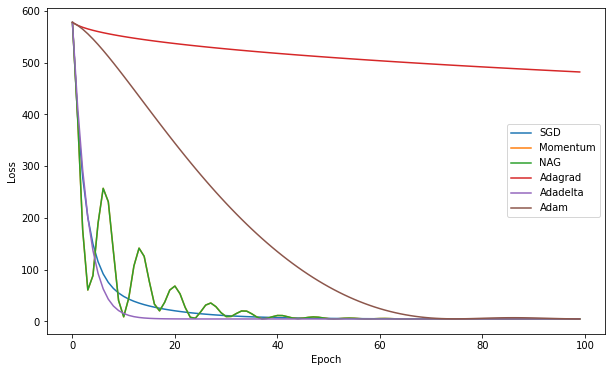

In [50]:
# Plot loss and name axes
plt.figure(figsize=(10, 6))

plt.plot(losses_sgd, label='SGD')
plt.plot(losses_momentum, label='Momentum')
plt.plot(losses_nag, label='NAG')
plt.plot(losses_adagrad, label='Adagrad')
plt.plot(losses_adadelta, label='Adadelta')
plt.plot(losses_adam, label='Adam')



plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

<i1> 1.2 Сравните реализованные методы на предложенном примере **(1 балл)**

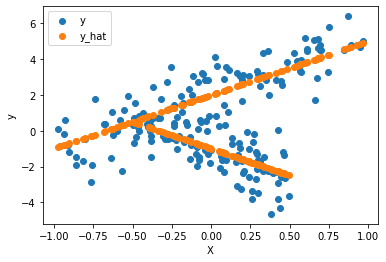

In [44]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

X2 = torch.ones(size, 2)
X2[:, 0].uniform_(-0.5, 0.5)

y_hat2 = -3 * X2[:, 0] - 1
y2 = y_hat2 + torch.randn(size)

X = torch.cat([X, X2], axis=0)
y = torch.cat([y, y2], axis=0)
y_hat = torch.cat([y_hat, y_hat2], axis=0)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

In [45]:
from torch.optim import SGD as TorchSGD

In [49]:
compare_optimizers(
    loss_animator, mse, 
    [
        ('SGD', SGD, {'lr': 1e-1}),
        ('Momentum', Momentum, {'lr': 1e-1, 'gamma': 0.9}),
        ('NAG', NAG, {'lr': 1e-1, 'gamma': 0.9}),
        ('Adagrad', Adagrad, {'lr': 1e-1}),
        ('Adadelta', Adadelta, {'gamma': 0.9}),
        ('Adam', Adam, {'lr': 1e-1}),
    ],
    start_point=[-5, -5],
    num_iter=100,
    step_skip=1
)

C:\Users\jaaj\AppData\Roaming\Python\Python39\site-packages\mpl_toolkits\mplot3d\proj3d.py:210: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
C:\Users\jaaj\AppData\Roaming\Python\Python39\site-packages\mpl_toolkits\mplot3d\proj3d.py:210: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones

#### На данном примере круче всех оказался Adadelta, сходимость за пару итерации. А хуже всех Adagrad, что неудивительно, ведь по его формуле происходит быстрое затухание и веса перестают обновляться. Также неплохо отработал Adam, достаточно ровненько сошелся, но скорость была сравнима с классическим SGD

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). Для обучения используйте оптимизаторы из первой части, а не из pytorch. </i> **(2 балла)**

In [52]:
#!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
#!tar -zxvf MNIST.tar.gz

x MNIST/
x MNIST/raw/
x MNIST/raw/train-labels-idx1-ubyte
x MNIST/raw/t10k-labels-idx1-ubyte.gz
x MNIST/raw/t10k-labels-idx1-ubyte
x MNIST/raw/t10k-images-idx3-ubyte.gz
x MNIST/raw/train-images-idx3-ubyte
x MNIST/raw/train-labels-idx1-ubyte.gz
x MNIST/raw/t10k-images-idx3-ubyte
x MNIST/raw/train-images-idx3-ubyte.gz
x MNIST/processed/
x MNIST/processed/training.pt
x MNIST/processed/test.pt


In [53]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

### Функция обучения

In [55]:
from tqdm.auto import tqdm
from IPython.display import clear_output

In [62]:
def train(network, optim, epochs=5):
    loss = nn.NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in tqdm(range(epochs)):
            losses = []
            accuracies = []
            for X, y in train_loader:
                network.zero_grad()
                # !!!
                #print(X.shape)
                pred = network(X)
                loss_batch = loss(pred, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optim.step()
                accuracies.append((np.argmax(pred.data.numpy(), 1) == y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            
            losses = []
            accuracies = []
            for X, y in test_loader:
                pred = network(X)
                loss_batch = loss(pred, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(pred.data.numpy(), 1) == y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

### MLP

In [63]:
mlp = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.LogSoftmax(dim=1)
)

### Обучение с Adam

Epoch 4... (Train/Test) NLL: 0.072/0.088	Accuracy: 0.978/0.974


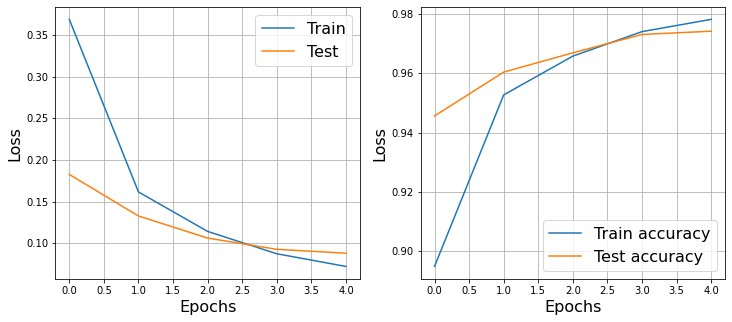

In [65]:
mlp = nn.Sequential(
    nn.Flatten(), # расстягиваем картинку в вектор
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.LogSoftmax(dim=1)
)
train(mlp, Adam(mlp.parameters(), lr=1e-4))

#### Мегабысто сошлись, но слегка переобучились :') Мб можно lr поменьше сделать, но я решил оставить везде один для однообразия + так было в прошлой дз

### Обучение с Adagrad

Epoch 4... (Train/Test) NLL: 1.073/1.005	Accuracy: 0.791/0.805


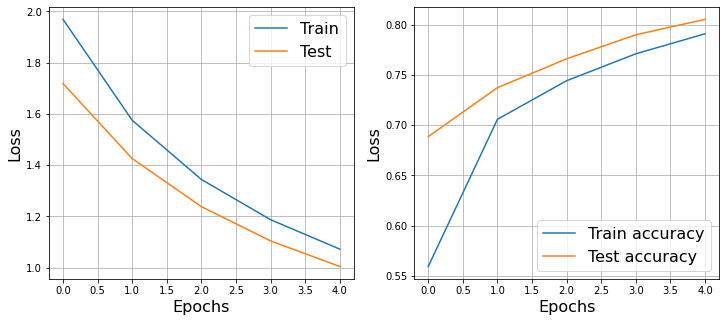

In [66]:
mlp = nn.Sequential(
    nn.Flatten(), # расстягиваем картинку в вектор
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.LogSoftmax(dim=1)
)
train(mlp, Adagrad(mlp.parameters(), lr=1e-4))

#### Сходится, но еле дошел до 0.8...Отставание от Adam на лицо. Короче Adagrad'у место в отстойнике))0)

### Обучение с AdaDelta

Хоба, а здесь и не надо learning rate указывать 

Epoch 4... (Train/Test) NLL: 23.488/30.057	Accuracy: 0.115/0.115


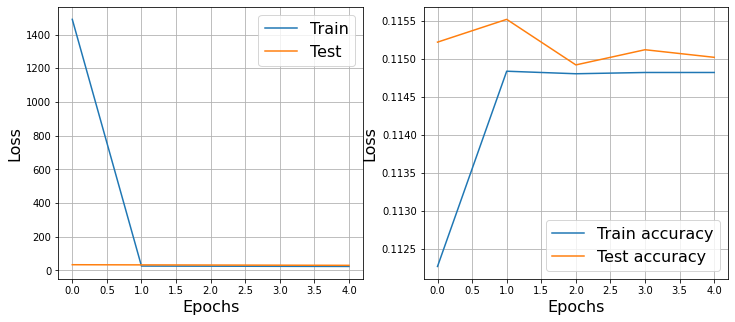

In [67]:
mlp = nn.Sequential(
    nn.Flatten(), # расстягиваем картинку в вектор
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.LogSoftmax(dim=1)
)
train(mlp, Adadelta(mlp.parameters()))

#### Я в шоках.....эт че такое ыыыы. Опозорился на всю страну!!! Adagrad и то лучше. Были большие надежды, судя по прошлым опытам, однако данная лосс оказалась ему не по зубам (( 

### Обучение с SGD

Epoch 4... (Train/Test) NLL: 1.971/1.911	Accuracy: 0.491/0.523


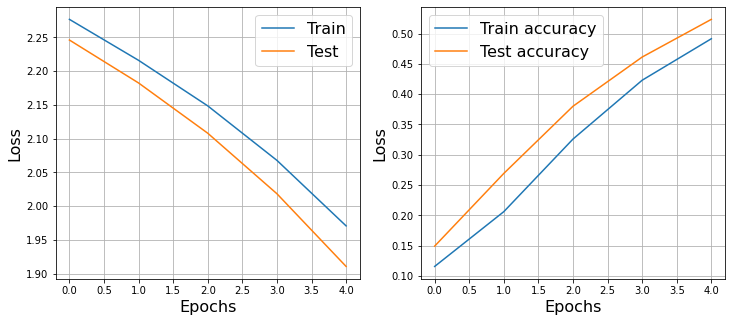

In [68]:
mlp = nn.Sequential(
    nn.Flatten(), # расстягиваем картинку в вектор
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.LogSoftmax(dim=1)
)
train(mlp, SGD(mlp.parameters(), lr=1e-4))

#### Ну что тут сказать, малый да удалый SGD! Медленно, но верно идет к своей цели. Нужно больше эпох для сходимости

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i> **(1 балл)**

### Сверточная нейронка

In [69]:
class ConvClassifier(nn.Module):
    def __init__(self):
        super(ConvClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.fc = nn.Sequential(nn.Linear(3200, 10), nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(self.relu(self.conv2(x)))
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.fc(x)
        return x

### Обучение с Adam

Epoch 4... (Train/Test) NLL: 0.045/0.042	Accuracy: 0.986/0.985


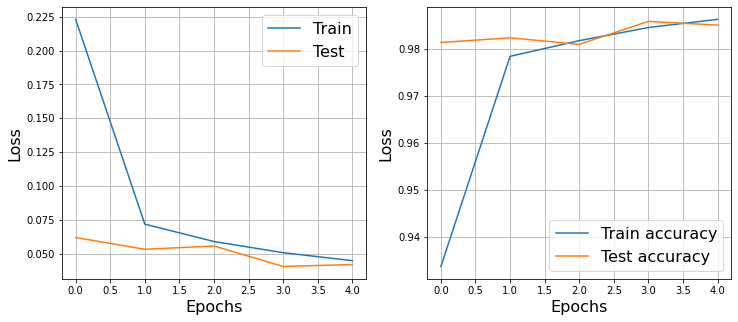

In [71]:
net = ConvClassifier()
train(net, Adam(net.parameters(), lr=1e-4))

#### Как всегда, на высоте. Моментальная сходимость (и снова даже переобучились эхх). ОДНАКО! на 4ой эпохе качество на тесте достигло 0.986, что выше чем при аналогичных параметрах и архитектурой, но с торчовым Adam'ом. Повод гордиться, наверное)()()

### Обучение с Adagrad

Epoch 4... (Train/Test) NLL: 0.526/0.489	Accuracy: 0.855/0.869


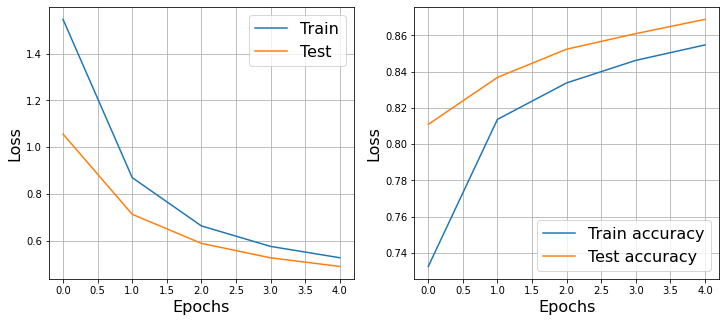

In [72]:
net = ConvClassifier()
train(net, Adagrad(net.parameters(), lr=1e-4))

#### Сходится и хорошо. Мб ему стоит дать побольше эпох и сойдется даже

### Обучение с AdaDelta

Epoch 4... (Train/Test) NLL: 84.155/54.328	Accuracy: 0.100/0.098


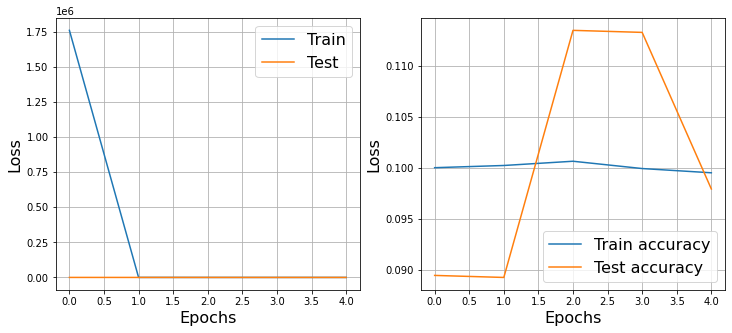

In [74]:
net = ConvClassifier()
train(net, Adadelta(net.parameters()))

#### No comments...просто какая-то вакханалия

### Обучение с SGD

Epoch 4... (Train/Test) NLL: 0.450/0.407	Accuracy: 0.871/0.881


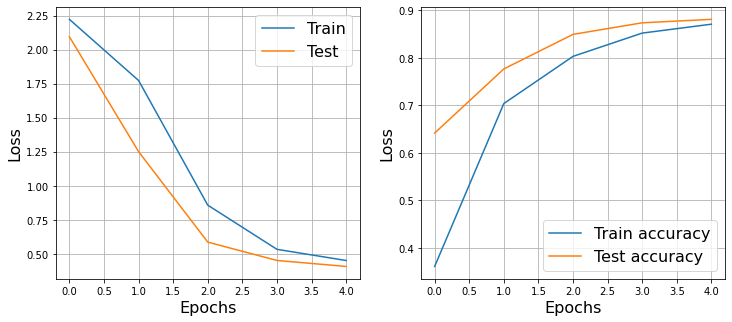

In [75]:
net = ConvClassifier()
train(net, SGD(net.parameters(), lr=1e-4))

#### SGD норм пацан, дотянул до 0.88, но дальше ему походу будет сложно. Мб угодил в локальный минимум

# Резюме

Посмотрев на поведение оптимизаторов в разных условиях можно сказать, что Adam подтвердил свою репутацию, как самый ходовой. Если не знаешь, что тебе надо, бери Adam!

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: